In [1]:
 import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.3.1'
spark_version = 'spark-3.3.2'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu focal InRelease
Get:2 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:4 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:7 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:8 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:9 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:10 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,058 kB]
Hit:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:12 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [2,776 kB]
Hit:13 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRelease
Get:14 http://

#Importing Packages


In [42]:
# Import packages
from pyspark.sql import SparkSession
from pyspark.sql import Row
from pyspark.sql.types import StructType, StructField, StringType, DateType, IntegerType
from pyspark import SparkFiles
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from pyspark.sql.functions import col
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a SparkSession
spark = SparkSession.builder.appName("NBA_Prediction").getOrCreate()


In [3]:
url2022 = 'https://project4nba.s3.amazonaws.com/2022_2023_NBA_Player_Stats_Transformed.csv'

url2021 = 'https://project4nba.s3.amazonaws.com/2021_2022_NBA_Player_Stats_Transformed.csv'

In [4]:
 # SparkFiles will allow you to resolves paths to files added through `SparkContext.addFile`

spark.sparkContext.addFile(url2022)

spark.sparkContext.addFile(url2021)

data2022 = spark.read.option('header', 'true').option("encoding", "utf-8").csv(SparkFiles.get("2022_2023_NBA_Player_Stats_Transformed.csv"), inferSchema=True, sep=',')

data2021 = spark.read.option('header', 'true').option("encoding", "utf-8").csv(SparkFiles.get("2021_2022_NBA_Player_Stats_Transformed.csv"), inferSchema=True, sep=';')

In [5]:
# Show DataFrame
data2022.show()

+---+--------------------+---+---+---+---+---+----+----+----+-----+---+---+-----+----+----+-----+-----+---+----+-----+---+---+----+---+---+---+---+---+----+
| Rk|              Player|Pos|Age| Tm|  G| GS|  MP|  FG| FGA|  FG%| 3P|3PA|  3P%|  2P| 2PA|  2P%| eFG%| FT| FTA|  FT%|ORB|DRB| TRB|AST|STL|BLK|TOV| PF| PTS|
+---+--------------------+---+---+---+---+---+----+----+----+-----+---+---+-----+----+----+-----+-----+---+----+-----+---+---+----+---+---+---+---+---+----+
|  1|    Precious Achiuwa|  C| 23|TOR| 55| 12|20.7| 3.6| 7.3|0.485|0.5|2.0|0.269| 3.0| 5.4|0.564|0.521|1.6| 2.3|0.702|1.8|4.1| 6.0|0.9|0.6|0.5|1.1|1.9| 9.2|
|  2|        Steven Adams|  C| 29|MEM| 42| 42|27.0| 3.7| 6.3|0.597|0.0|0.0|  0.0| 3.7| 6.2|0.599|0.597|1.1| 3.1|0.364|5.1|6.5|11.5|2.3|0.9|1.1|1.9|2.3| 8.6|
|  3|         Bam Adebayo|  C| 25|MIA| 75| 75|34.6| 8.0|14.9| 0.54|0.0|0.2|0.083| 8.0|14.7|0.545|0.541|4.3| 5.4|0.806|2.5|6.7| 9.2|3.2|1.2|0.8|2.5|2.8|20.4|
|  4|        Ochai Agbaji| SG| 22|UTA| 59| 22|20.5| 2.8| 6

In [6]:
# Show DataFrame
data2021.show()

+---+--------------------+---+---+---+---+---+----+----+----+-----+---+---+-----+---+----+-----+-----+---+----+-----+---+---+----+---+---+---+---+---+----+
| Rk|              Player|Pos|Age| Tm|  G| GS|  MP|  FG| FGA|  FG%| 3P|3PA|  3P%| 2P| 2PA|  2P%| eFG%| FT| FTA|  FT%|ORB|DRB| TRB|AST|STL|BLK|TOV| PF| PTS|
+---+--------------------+---+---+---+---+---+----+----+----+-----+---+---+-----+---+----+-----+-----+---+----+-----+---+---+----+---+---+---+---+---+----+
|  1|    Precious Achiuwa|  C| 22|TOR| 73| 28|23.6| 3.6| 8.3|0.439|0.8|2.1|0.359|2.9| 6.1|0.468|0.486|1.1| 1.8|0.595|2.0|4.5| 6.5|1.1|0.5|0.6|1.2|2.1| 9.1|
|  2|        Steven Adams|  C| 28|MEM| 76| 75|26.3| 2.8| 5.1|0.547|0.0|0.0|  0.0|2.8| 5.0|0.548|0.547|1.4| 2.6|0.543|4.6|5.4|10.0|3.4|0.9|0.8|1.5|2.0| 6.9|
|  3|         Bam Adebayo|  C| 24|MIA| 56| 56|32.6| 7.3|13.0|0.557|0.0|0.1|  0.0|7.3|12.9|0.562|0.557|4.6| 6.1|0.753|2.4|7.6|10.1|3.4|1.4|0.8|2.6|3.1|19.1|
|  4|        Santi Aldama| PF| 21|MEM| 32|  0|11.3| 1.7| 4.1|0.4

In [7]:
#Converting Spark DF to Pandas DF
nba_2022_2023_df = data2022.toPandas()

In [8]:
#Converting Spark DF to Pandas DF
nba_2021_2022_df = data2021.toPandas()

In [9]:
nba_2022_2023_df

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Precious Achiuwa,C,23,TOR,55,12,20.7,3.6,7.3,...,0.702,1.8,4.1,6.0,0.9,0.6,0.5,1.1,1.9,9.2
1,2,Steven Adams,C,29,MEM,42,42,27.0,3.7,6.3,...,0.364,5.1,6.5,11.5,2.3,0.9,1.1,1.9,2.3,8.6
2,3,Bam Adebayo,C,25,MIA,75,75,34.6,8.0,14.9,...,0.806,2.5,6.7,9.2,3.2,1.2,0.8,2.5,2.8,20.4
3,4,Ochai Agbaji,SG,22,UTA,59,22,20.5,2.8,6.5,...,0.812,0.7,1.3,2.1,1.1,0.3,0.3,0.7,1.7,7.9
4,5,Santi Aldama,PF,22,MEM,77,20,21.8,3.2,6.8,...,0.750,1.1,3.7,4.8,1.3,0.6,0.6,0.8,1.9,9.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
674,535,Thaddeus Young,PF,34,TOR,54,9,14.7,2.0,3.7,...,0.692,1.3,1.8,3.1,1.4,1.0,0.1,0.8,1.6,4.4
675,536,Trae Young,PG,24,ATL,73,73,34.8,8.2,19.0,...,0.886,0.8,2.2,3.0,10.2,1.1,0.1,4.1,1.4,26.2
676,537,Omer Yurtseven,C,24,MIA,9,0,9.2,1.8,3.0,...,0.833,0.9,1.7,2.6,0.2,0.2,0.2,0.4,1.8,4.4
677,538,Cody Zeller,C,30,MIA,15,2,14.5,2.5,3.9,...,0.686,1.7,2.6,4.3,0.7,0.2,0.3,0.9,2.2,6.5


In [10]:
nba_2021_2022_df

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Precious Achiuwa,C,22,TOR,73,28,23.6,3.6,8.3,...,0.595,2.0,4.5,6.5,1.1,0.5,0.6,1.2,2.1,9.1
1,2,Steven Adams,C,28,MEM,76,75,26.3,2.8,5.1,...,0.543,4.6,5.4,10.0,3.4,0.9,0.8,1.5,2.0,6.9
2,3,Bam Adebayo,C,24,MIA,56,56,32.6,7.3,13.0,...,0.753,2.4,7.6,10.1,3.4,1.4,0.8,2.6,3.1,19.1
3,4,Santi Aldama,PF,21,MEM,32,0,11.3,1.7,4.1,...,0.625,1.0,1.7,2.7,0.7,0.2,0.3,0.5,1.1,4.1
4,5,LaMarcus Aldridge,C,36,BRK,47,12,22.3,5.4,9.7,...,0.873,1.6,3.9,5.5,0.9,0.3,1.0,0.9,1.7,12.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,601,Thaddeus Young,PF,33,TOR,26,0,18.3,2.6,5.5,...,0.481,1.5,2.9,4.4,1.7,1.2,0.4,0.8,1.7,6.3
808,602,Trae Young,PG,23,ATL,76,76,34.9,9.4,20.3,...,0.904,0.7,3.1,3.7,9.7,0.9,0.1,4.0,1.7,28.4
809,603,Omer Yurtseven,C,23,MIA,56,12,12.6,2.3,4.4,...,0.623,1.5,3.7,5.3,0.9,0.3,0.4,0.7,1.5,5.3
810,604,Cody Zeller,C,29,POR,27,0,13.1,1.9,3.3,...,0.776,1.9,2.8,4.6,0.8,0.3,0.2,0.7,2.1,5.2


# Data Cleaning

In [11]:
#Merging the two datasets together
joined_data = nba_2022_2023_df.merge(nba_2021_2022_df, on='Player', how='outer')

In [12]:
joined_data

,Rk_x,Player,Pos_x,Age_x,Tm_x,G_x,GS_x,MP_x,FG_x,FGA_x,...,FT%_y,ORB_y,DRB_y,TRB_y,AST_y,STL_y,BLK_y,TOV_y,PF_y,PTS_y
0,1.0,Precious Achiuwa,C,23.0,TOR,55.0,12.0,20.7,3.6,7.3,...,0.595,2.0,4.5,6.5,1.1,0.5,0.6,1.2,2.1,9.1
1,2.0,Steven Adams,C,29.0,MEM,42.0,42.0,27.0,3.7,6.3,...,0.543,4.6,5.4,10.0,3.4,0.9,0.8,1.5,2.0,6.9
2,3.0,Bam Adebayo,C,25.0,MIA,75.0,75.0,34.6,8.0,14.9,...,0.753,2.4,7.6,10.1,3.4,1.4,0.8,2.6,3.1,19.1
3,4.0,Ochai Agbaji,SG,22.0,UTA,59.0,22.0,20.5,2.8,6.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,Santi Aldama,PF,22.0,MEM,77.0,20.0,21.8,3.2,6.8,...,0.625,1.0,1.7,2.7,0.7,0.2,0.3,0.5,1.1,4.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1098,NaN,Cassius Winston,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000,0.0,0.1,0.1,1.0,0.0,0.0,0.4,1.3,2.0
1099,NaN,Robert Woodard II,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000,0.4,0.5,0.9,0.3,0.1,0.1,0.1,0.3,0.6
1100,NaN,Moses Wright,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.000,0.3,0.5,0.8,0.5,0.0,0.3,0.0,0.0,1.3
1101,NaN,Moses Wright,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Check for missing values
joined_data.isna().sum()

Rk_x      269
Player      0
Pos_x     269
Age_x     269
Tm_x      269
G_x       269
GS_x      269
MP_x      269
FG_x      269
FGA_x     269
FG%_x     269
3P_x      269
3PA_x     269
3P%_x     269
2P_x      269
2PA_x     269
2P%_x     269
eFG%_x    269
FT_x      269
FTA_x     269
FT%_x     269
ORB_x     269
DRB_x     269
TRB_x     269
AST_x     269
STL_x     269
BLK_x     269
TOV_x     269
PF_x      269
PTS_x     269
Rk_y      127
Pos_y     127
Age_y     127
Tm_y      127
G_y       127
GS_y      127
MP_y      127
FG_y      127
FGA_y     127
FG%_y     127
3P_y      127
3PA_y     127
3P%_y     127
2P_y      127
2PA_y     127
2P%_y     127
eFG%_y    127
FT_y      127
FTA_y     127
FT%_y     127
ORB_y     127
DRB_y     127
TRB_y     127
AST_y     127
STL_y     127
BLK_y     127
TOV_y     127
PF_y      127
PTS_y     127
dtype: int64

In [14]:
#Dropping Nulls
joined_data.dropna(inplace = True)

In [15]:
# Check if values were dropped
joined_data.isna().sum()

Rk_x      0
Player    0
Pos_x     0
Age_x     0
Tm_x      0
G_x       0
GS_x      0
MP_x      0
FG_x      0
FGA_x     0
FG%_x     0
3P_x      0
3PA_x     0
3P%_x     0
2P_x      0
2PA_x     0
2P%_x     0
eFG%_x    0
FT_x      0
FTA_x     0
FT%_x     0
ORB_x     0
DRB_x     0
TRB_x     0
AST_x     0
STL_x     0
BLK_x     0
TOV_x     0
PF_x      0
PTS_x     0
Rk_y      0
Pos_y     0
Age_y     0
Tm_y      0
G_y       0
GS_y      0
MP_y      0
FG_y      0
FGA_y     0
FG%_y     0
3P_y      0
3PA_y     0
3P%_y     0
2P_y      0
2PA_y     0
2P%_y     0
eFG%_y    0
FT_y      0
FTA_y     0
FT%_y     0
ORB_y     0
DRB_y     0
TRB_y     0
AST_y     0
STL_y     0
BLK_y     0
TOV_y     0
PF_y      0
PTS_y     0
dtype: int64

In [16]:
joined_data

,Rk_x,Player,Pos_x,Age_x,Tm_x,G_x,GS_x,MP_x,FG_x,FGA_x,...,FT%_y,ORB_y,DRB_y,TRB_y,AST_y,STL_y,BLK_y,TOV_y,PF_y,PTS_y
0,1.0,Precious Achiuwa,C,23.0,TOR,55.0,12.0,20.7,3.6,7.3,...,0.595,2.0,4.5,6.5,1.1,0.5,0.6,1.2,2.1,9.1
1,2.0,Steven Adams,C,29.0,MEM,42.0,42.0,27.0,3.7,6.3,...,0.543,4.6,5.4,10.0,3.4,0.9,0.8,1.5,2.0,6.9
2,3.0,Bam Adebayo,C,25.0,MIA,75.0,75.0,34.6,8.0,14.9,...,0.753,2.4,7.6,10.1,3.4,1.4,0.8,2.6,3.1,19.1
4,5.0,Santi Aldama,PF,22.0,MEM,77.0,20.0,21.8,3.2,6.8,...,0.625,1.0,1.7,2.7,0.7,0.2,0.3,0.5,1.1,4.1
5,6.0,Nickeil Alexander-Walker,SG,24.0,TOT,59.0,3.0,15.0,2.2,5.0,...,0.743,0.6,2.3,2.9,2.4,0.7,0.4,1.4,1.6,10.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
829,535.0,Thaddeus Young,PF,34.0,TOR,54.0,9.0,14.7,2.0,3.7,...,0.481,1.5,2.9,4.4,1.7,1.2,0.4,0.8,1.7,6.3
830,536.0,Trae Young,PG,24.0,ATL,73.0,73.0,34.8,8.2,19.0,...,0.904,0.7,3.1,3.7,9.7,0.9,0.1,4.0,1.7,28.4
831,537.0,Omer Yurtseven,C,24.0,MIA,9.0,0.0,9.2,1.8,3.0,...,0.623,1.5,3.7,5.3,0.9,0.3,0.4,0.7,1.5,5.3
832,538.0,Cody Zeller,C,30.0,MIA,15.0,2.0,14.5,2.5,3.9,...,0.776,1.9,2.8,4.6,0.8,0.3,0.2,0.7,2.1,5.2


In [17]:
joined_data.dtypes

Rk_x      float64
Player     object
Pos_x      object
Age_x     float64
Tm_x       object
G_x       float64
GS_x      float64
MP_x      float64
FG_x      float64
FGA_x     float64
FG%_x     float64
3P_x      float64
3PA_x     float64
3P%_x     float64
2P_x      float64
2PA_x     float64
2P%_x     float64
eFG%_x    float64
FT_x      float64
FTA_x     float64
FT%_x     float64
ORB_x     float64
DRB_x     float64
TRB_x     float64
AST_x     float64
STL_x     float64
BLK_x     float64
TOV_x     float64
PF_x      float64
PTS_x     float64
Rk_y      float64
Pos_y      object
Age_y     float64
Tm_y       object
G_y       float64
GS_y      float64
MP_y      float64
FG_y      float64
FGA_y     float64
FG%_y     float64
3P_y      float64
3PA_y     float64
3P%_y     float64
2P_y      float64
2PA_y     float64
2P%_y     float64
eFG%_y    float64
FT_y      float64
FTA_y     float64
FT%_y     float64
ORB_y     float64
DRB_y     float64
TRB_y     float64
AST_y     float64
STL_y     float64
BLK_y     

# Linear Regression

In [18]:
joined_data = joined_data.set_index('Player')

In [19]:
joined_data

,Rk_x,Pos_x,Age_x,Tm_x,G_x,GS_x,MP_x,FG_x,FGA_x,FG%_x,...,FT%_y,ORB_y,DRB_y,TRB_y,AST_y,STL_y,BLK_y,TOV_y,PF_y,PTS_y
Player,,,,,,,,,,,,,,,,,,,,,
Precious Achiuwa,1.0,C,23.0,TOR,55.0,12.0,20.7,3.6,7.3,0.485,...,0.595,2.0,4.5,6.5,1.1,0.5,0.6,1.2,2.1,9.1
Steven Adams,2.0,C,29.0,MEM,42.0,42.0,27.0,3.7,6.3,0.597,...,0.543,4.6,5.4,10.0,3.4,0.9,0.8,1.5,2.0,6.9
Bam Adebayo,3.0,C,25.0,MIA,75.0,75.0,34.6,8.0,14.9,0.540,...,0.753,2.4,7.6,10.1,3.4,1.4,0.8,2.6,3.1,19.1
Santi Aldama,5.0,PF,22.0,MEM,77.0,20.0,21.8,3.2,6.8,0.470,...,0.625,1.0,1.7,2.7,0.7,0.2,0.3,0.5,1.1,4.1
Nickeil Alexander-Walker,6.0,SG,24.0,TOT,59.0,3.0,15.0,2.2,5.0,0.444,...,0.743,0.6,2.3,2.9,2.4,0.7,0.4,1.4,1.6,10.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Thaddeus Young,535.0,PF,34.0,TOR,54.0,9.0,14.7,2.0,3.7,0.545,...,0.481,1.5,2.9,4.4,1.7,1.2,0.4,0.8,1.7,6.3
Trae Young,536.0,PG,24.0,ATL,73.0,73.0,34.8,8.2,19.0,0.429,...,0.904,0.7,3.1,3.7,9.7,0.9,0.1,4.0,1.7,28.4
Omer Yurtseven,537.0,C,24.0,MIA,9.0,0.0,9.2,1.8,3.0,0.593,...,0.623,1.5,3.7,5.3,0.9,0.3,0.4,0.7,1.5,5.3


In [20]:
# Select the features (X) and target variables (y) for points (PTS)

features = joined_data.drop(['PTS_x', 'Pos_x', 'Pos_y', 'Tm_x', 'Tm_y', 'Rk_y', 'Rk_x'], axis = 1)

target_pts = joined_data[['PTS_x']]

In [21]:
# Split the data into training and test sets
X_train, X_test, y_train_pts, y_test_pts = train_test_split(features, target_pts, test_size=0.25, random_state=42)

In [22]:
# Create separate models for points
model_pts = LinearRegression()

# Train the models
model_pts.fit(X_train, y_train_pts)

LinearRegression()

In [23]:
# Calculate R-squared for the model
r_squared = model_pts.score(X_train, y_train_pts)

r_squared

0.999886061633242

In [24]:
full_set = pd.concat([X_train, X_test])

In [25]:
full_set.columns

Index(['Age_x', 'G_x', 'GS_x', 'MP_x', 'FG_x', 'FGA_x', 'FG%_x', '3P_x',
       '3PA_x', '3P%_x', '2P_x', '2PA_x', '2P%_x', 'eFG%_x', 'FT_x', 'FTA_x',
       'FT%_x', 'ORB_x', 'DRB_x', 'TRB_x', 'AST_x', 'STL_x', 'BLK_x', 'TOV_x',
       'PF_x', 'Age_y', 'G_y', 'GS_y', 'MP_y', 'FG_y', 'FGA_y', 'FG%_y',
       '3P_y', '3PA_y', '3P%_y', '2P_y', '2PA_y', '2P%_y', 'eFG%_y', 'FT_y',
       'FTA_y', 'FT%_y', 'ORB_y', 'DRB_y', 'TRB_y', 'AST_y', 'STL_y', 'BLK_y',
       'TOV_y', 'PF_y', 'PTS_y'],
      dtype='object')

In [26]:
# Make predictions for points
pts_predictions = model_pts.predict(full_set)

# RandomForestRegressor

In [27]:
from sklearn.ensemble import RandomForestRegressor

In [28]:
model_pts_forest = RandomForestRegressor()

In [29]:
model_pts_forest.fit(X_train, y_train_pts)

<ipython-input-29-606d44bd8ffc>:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_pts_forest.fit(X_train, y_train_pts)


RandomForestRegressor()

In [32]:
r_squared_forest = model_pts_forest.score(X_train, y_train_pts)

# Print R-squared for linear regression and random forest regression
print("Linear Regression R-squared:", r_squared)
print("Random Forest Regression R-squared:", r_squared_forest)

Linear Regression R-squared: 0.999886061633242
Random Forest Regression R-squared: 0.9987107074710001


In [31]:
pts_predictions_forest = model_pts_forest.predict(full_set)

#Testing Prediction using Random Player

In [34]:
player_names = full_set.index.unique()

player_names

Index(['Tyus Jones', 'Goran Dragi?', 'Larry Nance Jr.', 'Evan Fournier',
       'Davon Reed', 'James Harden', 'Devin Vassell', 'Luka Don?i?',
       'Eugene Omoruyi', 'Ish Smith',
       ...
       'Thanasis Antetokounmpo', 'Dejounte Murray', 'Monte Morris',
       'Bobby Portis', 'Khem Birch', 'Klay Thompson', 'Cory Joseph',
       'Darius Garland', 'Garrett Temple', 'Isaiah Jackson'],
      dtype='object', name='Player', length=428)

In [35]:
# Import Random
import random
# Make prediction for randomly selected player
player_names = joined_data.index.unique()
select_player = random.choice(player_names)
player_row = joined_data[joined_data.index == select_player]
player_features = player_row.drop(['PTS_x', 'Pos_x', 'Pos_y', 'Tm_x', 'Tm_y', 'Rk_y', 'Rk_x'], axis = 1)

In [36]:
# Get the actual points for the player
pts_actual = player_row[['PTS_x']].values[0]
pts_actual_2021 = player_row[['PTS_y']].values[0]
# Predict points and assists for the player
pts_predicted = model_pts.predict(player_features)[0]
print("Player:", select_player)
print("2021-2022 Points:", pts_actual_2021)
print("2022-2023 Points:", pts_actual)
print("2023-2024 Predicted Points:", pts_predicted)


Player: Sam Hauser
2021-2022 Points: [2.5]
2022-2023 Points: [6.4]
2023-2024 Predicted Points: [6.54226969]


In [37]:
#Dropping 2021-2022 NBA age
columns_to_drop = ['Age_y']
joined_data.drop(columns=columns_to_drop, inplace=True)

In [38]:
#Verifying Age_y was dropped
joined_data.columns

Index(['Rk_x', 'Pos_x', 'Age_x', 'Tm_x', 'G_x', 'GS_x', 'MP_x', 'FG_x',
       'FGA_x', 'FG%_x', '3P_x', '3PA_x', '3P%_x', '2P_x', '2PA_x', '2P%_x',
       'eFG%_x', 'FT_x', 'FTA_x', 'FT%_x', 'ORB_x', 'DRB_x', 'TRB_x', 'AST_x',
       'STL_x', 'BLK_x', 'TOV_x', 'PF_x', 'PTS_x', 'Rk_y', 'Pos_y', 'Tm_y',
       'G_y', 'GS_y', 'MP_y', 'FG_y', 'FGA_y', 'FG%_y', '3P_y', '3PA_y',
       '3P%_y', '2P_y', '2PA_y', '2P%_y', 'eFG%_y', 'FT_y', 'FTA_y', 'FT%_y',
       'ORB_y', 'DRB_y', 'TRB_y', 'AST_y', 'STL_y', 'BLK_y', 'TOV_y', 'PF_y',
       'PTS_y'],
      dtype='object')

In [39]:
#Renaming Columns
renamed_columns = {}
for col in joined_data.columns:
    if col.endswith('_x'):
        renamed_columns[col] = col[:-2] + '_2022_2023'
    elif col.endswith('_y'):
        renamed_columns[col] = col[:-2] + '_2021_2022'
joined_data.rename(columns=renamed_columns, inplace=True)


#Exporting CSV for Visualizations

In [40]:
# Create a copy of pandas_df
pandas_df_with_predictions = joined_data.copy()

# Add the predictions as new columns
pandas_df_with_predictions['2023-2024 Predicted Points'] = pts_predictions

# Set negative predictions to 0
pandas_df_with_predictions.loc[pandas_df_with_predictions['2023-2024 Predicted Points'] < 0, '2023-2024 Predicted Points'] = 0

#Reset index and add as column

pandas_df_with_predictions = pandas_df_with_predictions.reset_index(drop = False)

# Specify the path where you want to save the file
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/NBA Predicted Data.csv'
# Save the DataFrame as a CSV file
pandas_df_with_predictions.to_csv(file_path, encoding='utf-8', index=False)


MessageError: ignored

In [57]:
pandas_df_with_predictions.columns

Index(['Player', 'Rk_2022_2023', 'Pos_2022_2023', 'Age_2022_2023',
       'Tm_2022_2023', 'G_2022_2023', 'GS_2022_2023', 'MP_2022_2023',
       'FG_2022_2023', 'FGA_2022_2023', 'FG%_2022_2023', '3P_2022_2023',
       '3PA_2022_2023', '3P%_2022_2023', '2P_2022_2023', '2PA_2022_2023',
       '2P%_2022_2023', 'eFG%_2022_2023', 'FT_2022_2023', 'FTA_2022_2023',
       'FT%_2022_2023', 'ORB_2022_2023', 'DRB_2022_2023', 'TRB_2022_2023',
       'AST_2022_2023', 'STL_2022_2023', 'BLK_2022_2023', 'TOV_2022_2023',
       'PF_2022_2023', 'PTS_2022_2023', 'Rk_2021_2022', 'Pos_2021_2022',
       'Tm_2021_2022', 'G_2021_2022', 'GS_2021_2022', 'MP_2021_2022',
       'FG_2021_2022', 'FGA_2021_2022', 'FG%_2021_2022', '3P_2021_2022',
       '3PA_2021_2022', '3P%_2021_2022', '2P_2021_2022', '2PA_2021_2022',
       '2P%_2021_2022', 'eFG%_2021_2022', 'FT_2021_2022', 'FTA_2021_2022',
       'FT%_2021_2022', 'ORB_2021_2022', 'DRB_2021_2022', 'TRB_2021_2022',
       'AST_2021_2022', 'STL_2021_2022', 'BLK_2021_

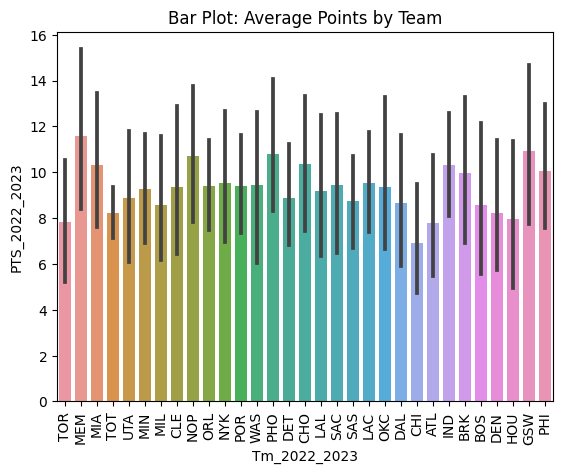

In [50]:
sns.barplot(x='Tm_2022_2023', y='PTS_2022_2023', data=pandas_df_with_predictions)
plt.title('Bar Plot: Average Points by Team')
plt.xticks(rotation=90)
plt.show()


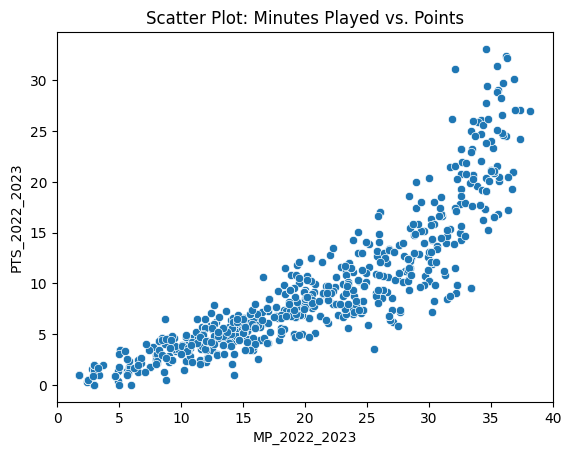

In [53]:
sns.scatterplot(x='MP_2022_2023', y='PTS_2022_2023', data=pandas_df_with_predictions)
plt.title('Scatter Plot: Minutes Played vs. Points')
plt.show()


In [58]:
pandas_df_with_predictions.columns

Index(['Player', 'Rk_2022_2023', 'Pos_2022_2023', 'Age_2022_2023',
       'Tm_2022_2023', 'G_2022_2023', 'GS_2022_2023', 'MP_2022_2023',
       'FG_2022_2023', 'FGA_2022_2023', 'FG%_2022_2023', '3P_2022_2023',
       '3PA_2022_2023', '3P%_2022_2023', '2P_2022_2023', '2PA_2022_2023',
       '2P%_2022_2023', 'eFG%_2022_2023', 'FT_2022_2023', 'FTA_2022_2023',
       'FT%_2022_2023', 'ORB_2022_2023', 'DRB_2022_2023', 'TRB_2022_2023',
       'AST_2022_2023', 'STL_2022_2023', 'BLK_2022_2023', 'TOV_2022_2023',
       'PF_2022_2023', 'PTS_2022_2023', 'Rk_2021_2022', 'Pos_2021_2022',
       'Tm_2021_2022', 'G_2021_2022', 'GS_2021_2022', 'MP_2021_2022',
       'FG_2021_2022', 'FGA_2021_2022', 'FG%_2021_2022', '3P_2021_2022',
       '3PA_2021_2022', '3P%_2021_2022', '2P_2021_2022', '2PA_2021_2022',
       '2P%_2021_2022', 'eFG%_2021_2022', 'FT_2021_2022', 'FTA_2021_2022',
       'FT%_2021_2022', 'ORB_2021_2022', 'DRB_2021_2022', 'TRB_2021_2022',
       'AST_2021_2022', 'STL_2021_2022', 'BLK_2021_

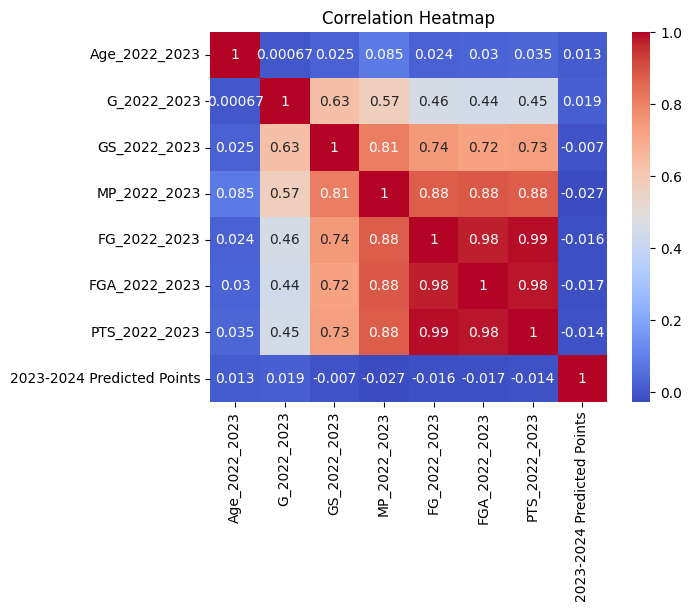

In [60]:
numeric_columns = ['Age_2022_2023', 'G_2022_2023', 'GS_2022_2023', 'MP_2022_2023', 'FG_2022_2023', 'FGA_2022_2023', 'PTS_2022_2023', '2023-2024 Predicted Points']
numeric_data = pandas_df_with_predictions[numeric_columns]
corr_matrix = numeric_data.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()
